## Coding for Lecture V Maximum A Posteriori Estimation

by *Suwichaya Suwanwimolkul, Ph.D.*

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GenAI-CUEE/Estimation-Theory-EE523/blob/master/Tutorial4/main.ipynb) 

The coding exercies and examples are used as parts of  *Lecture VI: LMSE, Wiener Filtering, Maximum A Posteriori*  in **Estimation Theory EE2102523**. 

The topics covered in this exercise are: 
- [Maximum A Posteriori Estimation](#maximum-a-posteriori-estimation)
    - [The MAP Algorithm](#map-algorithm)
    - [Extension to estimate parameters in priors](#extend-the-map-estimator-to-update-the-parameters-of-prior-distribution)
    - [Apply to reconstruct compressed data using MAP](#apply-map-estimation)
    - [Apply to reconstruct compressed data using MLE](#what-if-there-is-no-prior--using-mle)
    - [Compairison](#plot-outputs)

Note: Don't forget to do `pip install -r requirements.txt`

References:

1. How to check https://online.stat.psu.edu/stat510/
2. Coding (in matlab version): https://dspcookbook.github.io/ ...


In [ ]:
! pip install numpy pandas tqdm matplotlib joypy torch torchvision torchaudio

In [2]:
import numpy as np 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 
import numpy as np
from scipy.linalg import toeplitz 
import pdb

## Maximum A Posteriori Estimation

### MAP Algorithm

The likelihood $f_{Y|X}(y|x)$ is $ f_{Y|X}(y|x) = \mathcal{N}(AX, \sigma_V^2)$, and the prior $f_{X}(x)$  is $ f_{X}(x) = \text{Laplacian}(X; \lambda, \mu)$.  

 
Thus, the MAP can be formulated by  
$$\argmin_{x \in \mathcal{R}^N}  \frac{1}{\sigma_V^2} {|| y - Ax ||^2_2} +  \lambda^{-1} || x - \mu||_1  $$  

This steps follow the equations provided in the lecture...

That is, the solutions to this problem are in a soft thresholding form: 

\begin{align}
    x_j^{MAP} = 
    \begin{cases}
        \frac{1}{2} (2 y^T A_j - \lambda^{-1}_j \sigma^2_V), &\text{if}~x_j > \mu_j   \\
        \frac{1}{2} (2 y^T A_j + \lambda^{-1}_j \sigma^2_V), &\text{if}~x_j < \mu_j    \\
        0, &\text{otherwise}.
    \end{cases}
\end{align}

Note that in the code below we add the condition there $x_j > 0$ since they are representing pixel values.

In [3]:
def MAPEstimator(y, A, sigma_v, lambda_gamm, mu_gamma): 

    dff = sigma_v/(2*lambda_gamm  )
 
    X   = (y.transpose().dot(A)).transpose()

    x_return = np.zeros_like(X) 
    value_a = X - dff   

    case_a  = (value_a > mu_gamma) *(value_a > 0 )
    x_return[case_a] = value_a[case_a]
 
    value_b = X + dff  
    case_b  = (value_b < mu_gamma ) *(value_b > 0 )
    x_return[case_b] = value_b[case_b]
     
    return x_return

### Extend the MAP Estimator to update the parameters of prior distribution

We estimate the parameters in prior distribution, namely $\mu$ and $\lambda$ in $\text{Laplacian}(X; \lambda, \mu)$.

We can solve for this via maximum likelihood estimation:

$$ \argmin_{\lambda, \mu}  \sum_{i=1}^N  (  \frac{|x_i - \mu|}{b} - \log{\frac{1}{2b}}) $$ 

For this, we can estimate these two parameters as follows:
- $\partial_{\mu} \mathcal{L}_{Lap}(X; \lambda, \mu)  \Rightarrow   \mu = \frac{\sum_i x_i}{N}$
- $\partial_{b} \mathcal{L}_{Lap}(X; \lambda, \mu)  \Rightarrow   \lambda    = \frac{\sum_i |x_i - \mu|}{N} $


In [4]:
## These functions are used to update the mu and lambda in Laplacian Distribution

def update_lambda(data2D):
    mean_2d = np.mean(data2D, axis=2)
    b = np.mean(np.abs(data2D - mean_2d.reshape(28,28,1)), axis=2) 
    return b

def sample_mean(data2D):
    mean_2d = np.mean(data2D, axis=2)    
    return mean_2d

In [5]:
def loopy_Estimation(y, A, sigma_v, lambda_gamm, mu_gamma, num_iteration):
    mu_gamma_updated    = mu_gamma
    lambda_gamm_updated = lambda_gamm
    Num_samples = y.shape[1]
    x_return_list = [] 
    for i in range(num_iteration):
        x_return = MAPEstimator(y, A, sigma_v, lambda_gamm_updated, mu_gamma_updated)  
        data2D_update       = x_return.reshape(28,28, Num_samples) 
        mu_gamma_updated    = sample_mean(data2D_update) 
        mu_gamma_updated    = mu_gamma_updated.reshape(28*28,1)

        lambda_gamm_updated = update_lambda(data2D_update) 
        lambda_gamm_updated = lambda_gamm_updated.reshape(28*28,1)
        x_return_list.append(x_return)
  
        
    return x_return_list

#### Load Data

In [6]:
import numpy as np 
import matplotlib.pyplot as plt 
import numpy as np 

import torch.utils.data  
from torchvision import datasets, transforms 


test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True,
                transform=transforms.ToTensor()), batch_size=1, shuffle=False)

data_vect = []
label_vect_ = []
for i, (data, label) in enumerate(test_loader):
    data_vect.append(data.view(28,28).numpy())
    label_vect_.append(label.numpy()[0])

label_vect  = np.array(label_vect_)
data2D      = np.stack(data_vect, axis=-1)
Num_samples = data2D.shape[2]

#### Simulation Settings

In [7]:
sigma_v           = 1e-10
num_iteration     = 1
compression_ratio = 0.5

n_compressed_data = int(compression_ratio*28*28) 
A                 = np.random.randn(n_compressed_data, 28*28)/(np.sqrt(n_compressed_data))  
v                 = sigma_v*np.random.randn(1, 1)  
yA                = A.dot(data2D.reshape(28*28,-1)).reshape(n_compressed_data,-1)  

y                 = yA  + v  

### Apply MAP Estimation

In [8]:
mu_gamma_    = sample_mean(data2D)
mu_gamma    =  mu_gamma_.reshape(28*28,1)

lambda_gamm_ = update_lambda(data2D)  
lambda_gamm  = lambda_gamm_.reshape(28*28,1)

x_hat_list   = loopy_Estimation(y, A,  0.01, lambda_gamm, mu_gamma, num_iteration)

/tmp/ipykernel_30228/3819130981.py:3: RuntimeWarning: divide by zero encountered in divide
  dff = sigma_v/(2*lambda_gamm  )


#### Let's look at the priors

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_30228/3667060648.py:4: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_title("Gamma's parameter:$\mu$")
/tmp/ipykernel_30228/3667060648.py:6: SyntaxWarning: invalid escape sequence '\l'
  ax[1].set_title("Gamma's parameter:$\lambda$")


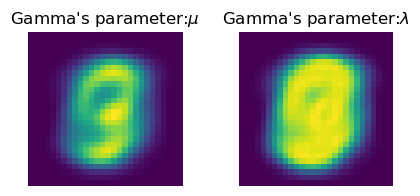

In [9]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(5,2) )

ax[0].imshow(mu_gamma.reshape(28,28)) 
ax[0].set_title("Gamma's parameter:$\mu$")
ax[1].imshow(lambda_gamm.reshape(28,28))
ax[1].set_title("Gamma's parameter:$\lambda$")

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.show()


### What if there is no prior ... (using MLE)

This is equivalent to solving for $x$ via

$$\argmin_{x \in \mathcal{R}^N}   \frac{1}{\sigma_V^2} {|| y - Ax ||^2_2} $$

but $A$ is an orthogonal matrix. Thus, $ \hat{x}_{no prior} = y^T A$

In [10]:
X_no_prior  = (y.transpose().dot(A)).transpose()
X_no_prior_all = X_no_prior.reshape(28,28,-1)

X_hat_no_prior_plot = X_no_prior_all[:,:,0]

### Plot outputs

In [11]:
image_system =  mpimg.imread('system.png')

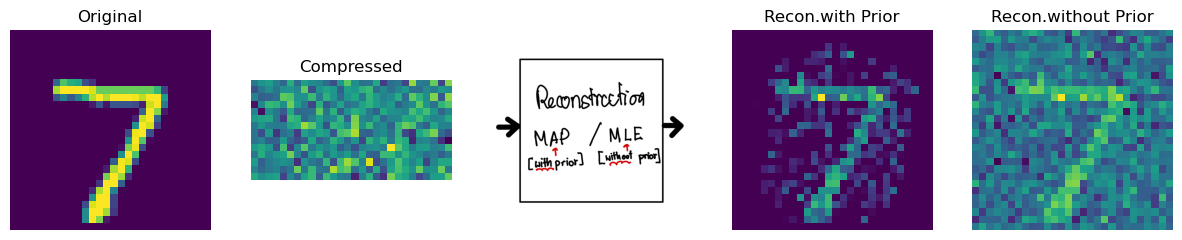

In [12]:
Num_samples       = y.shape[1]

x_hat_with_prior    = x_hat_list[0].reshape(28,28, Num_samples)[:,:,0]     

fig, ax = plt.subplots(nrows=1,ncols=5, figsize=(15,5) )

ax[0].imshow(data2D[:,:,0] ) 
ax[0].set_title("Original")
ax[1].imshow(y[:,0].reshape(-1,28)) 
ax[1].set_title("Compressed")
ax[2].imshow(image_system) 

ax[3].imshow(x_hat_with_prior) 
ax[3].set_title("Recon.with Prior")

ax[4].imshow(X_hat_no_prior_plot) 
ax[4].set_title("Recon.without Prior")

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
ax[3].set_axis_off()
ax[4].set_axis_off()

 

plt.show()